In [1]:
import os
import squidpy as sq
import pandas as pd
import scanpy as sc
import numpy as np

import alphashape
import matplotlib as mpl
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

/share/appspace_data/shared_groups/bgi_liujz_bgi_liujz/soft/Miniconda3/envs/squidpy_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("/share/appspace_data/shared_groups/bgi_liujz_bgi_liujz/wujunshu")

In [3]:
plt.style.use("dark_background")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
colors = ["darkgrey", "yellow"]
cmap = LinearSegmentedColormap.from_list("CustomCmap", colors)

### Plot_spatial

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

def get_rgb_function(cmap, min_value, max_value):
    r"""Generate a function to map continous values to RGB values using colormap between min_value & max_value."""

    if min_value > max_value:
        raise ValueError("Max_value should be greater or than min_value.")

    if min_value == max_value:
        warnings.warn(
            "Max_color is equal to min_color. It might be because of the data or bad parameter choice. "
            "If you are using plot_contours function try increasing max_color_quantile parameter and"
            "removing cell types with all zero values."
        )

        def func_equal(x):
            factor = 0 if max_value == 0 else 0.5
            return cmap(np.ones_like(x) * factor)

        return func_equal

    def func(x):
        return cmap((np.clip(x, min_value, max_value) - min_value) / (max_value - min_value))

    return func


def rgb_to_ryb(rgb):
    """
    Converts colours from RGB colorspace to RYB

    Parameters
    ----------

    rgb
        numpy array Nx3

    Returns
    -------
    Numpy array Nx3
    """
    rgb = np.array(rgb)
    if len(rgb.shape) == 1:
        rgb = rgb[np.newaxis, :]

    white = rgb.min(axis=1)
    black = (1 - rgb).min(axis=1)
    rgb = rgb - white[:, np.newaxis]

    yellow = rgb[:, :2].min(axis=1)
    ryb = np.zeros_like(rgb)
    ryb[:, 0] = rgb[:, 0] - yellow
    ryb[:, 1] = (yellow + rgb[:, 1]) / 2
    ryb[:, 2] = (rgb[:, 2] + rgb[:, 1] - yellow) / 2

    mask = ~(ryb == 0).all(axis=1)
    if mask.any():
        norm = ryb[mask].max(axis=1) / rgb[mask].max(axis=1)
        ryb[mask] = ryb[mask] / norm[:, np.newaxis]

    return ryb + black[:, np.newaxis]


def ryb_to_rgb(ryb):
    """
    Converts colours from RYB colorspace to RGB

    Parameters
    ----------

    ryb
        numpy array Nx3

    Returns
    -------
    Numpy array Nx3
    """
    ryb = np.array(ryb)
    if len(ryb.shape) == 1:
        ryb = ryb[np.newaxis, :]

    black = ryb.min(axis=1)
    white = (1 - ryb).min(axis=1)
    ryb = ryb - black[:, np.newaxis]

    green = ryb[:, 1:].min(axis=1)
    rgb = np.zeros_like(ryb)
    rgb[:, 0] = ryb[:, 0] + ryb[:, 1] - green
    rgb[:, 1] = green + ryb[:, 1]
    rgb[:, 2] = (ryb[:, 2] - green) * 2

    mask = ~(ryb == 0).all(axis=1)
    if mask.any():
        norm = rgb[mask].max(axis=1) / ryb[mask].max(axis=1)
        rgb[mask] = rgb[mask] / norm[:, np.newaxis]

    return rgb + white[:, np.newaxis]


def plot_spatial_general(
    value_df,
    coords,
    labels,
    text=None,
    circle_diameter=4.0,
    alpha_scaling=1.0,
    max_col=(np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf),
    max_color_quantile=0.98,
    show_img=True,
    img=None,
    img_alpha=1.0,
    adjust_text=False,
    plt_axis="off",
    axis_y_flipped=True,
    x_y_labels=("", ""),
    crop_x=None,
    crop_y=None,
    text_box_alpha=0.9,
    reorder_cmap=range(7),
    style="fast",
    colorbar_position="bottom",
    colorbar_label_kw={},
    colorbar_shape={},
    colorbar_tick_size=12,
    colorbar_grid=None,
    image_cmap="Greys_r",
    white_spacing=40,
    max_value=None
):
    r"""Plot spatial abundance of cell types (regulatory programmes) with colour gradient and interpolation.

      This method supports only 7 cell types with these colours (in order, which can be changed using reorder_cmap).
      'yellow' 'orange' 'blue' 'green' 'purple' 'grey' 'white'

    :param value_df: pd.DataFrame - with cell abundance or other features (only 7 allowed, columns) across locations (rows)
    :param coords: np.ndarray - x and y coordinates (in columns) to be used for ploting spots
    :param text: pd.DataFrame - with x, y coordinates, text to be printed
    :param circle_diameter: diameter of circles
    :param labels: list of strings, labels of cell types
    :param alpha_scaling: adjust color alpha
    :param max_col: crops the colorscale maximum value for each column in value_df.
    :param max_color_quantile: crops the colorscale at x quantile of the data.
    :param show_img: show image?
    :param img: numpy array representing a tissue image.
        If not provided a black background image is used.
    :param img_alpha: transparency of the image
    :param lim: x and y max limits on the plot. Minimum is always set to 0, if `lim` is None maximum
        is set to image height and width. If 'no_limit' then no limit is set.
    :param adjust_text: move text label to prevent overlap
    :param plt_axis: show axes?
    :param axis_y_flipped: flip y axis to match coordinates of the plotted image
    :param reorder_cmap: reorder colors to make sure you get the right color for each category

    :param style: plot style (matplolib.style.context):
        'fast' - white background & dark text;
        'dark_background' - black background & white text;

    :param colorbar_position: 'bottom', 'right' or None
    :param colorbar_label_kw: dict that will be forwarded to ax.set_label()
    :param colorbar_shape: dict {'vertical_gaps': 1.5, 'horizontal_gaps': 1.5,
                                    'width': 0.2, 'height': 0.2}, not obligatory to contain all params
    :param colorbar_tick_size: colorbar ticks label size
    :param colorbar_grid: tuple of colorbar grid (rows, columns)
    :param image_cmap: matplotlib colormap for grayscale image
    :param white_spacing: percent of colorbars to be hidden

    """

    if value_df.shape[1] > 7:
        raise ValueError("Maximum of 7 cell types / factors can be plotted at the moment")

    def create_colormap(R, G, B):
        spacing = int(white_spacing * 2.55)

        N = 255
        M = 3

        alphas = np.concatenate([[0] * spacing * M, np.linspace(0, 1.0, (N - spacing) * M)])

        vals = np.ones((N * M, 4))
        #         vals[:, 0] = np.linspace(1, R / 255, N * M)
        #         vals[:, 1] = np.linspace(1, G / 255, N * M)
        #         vals[:, 2] = np.linspace(1, B / 255, N * M)
        for i, color in enumerate([R, G, B]):
            vals[:, i] = color / 255
        vals[:, 3] = alphas

        return ListedColormap(vals)

    # Create linearly scaled colormaps
    YellowCM = create_colormap(240, 228, 66)  # #F0E442 ['#F0E442', '#D55E00', '#56B4E9',
    # '#009E73', '#5A14A5', '#C8C8C8', '#323232']
    RedCM = create_colormap(213, 94, 0)  # #D55E00
    BlueCM = create_colormap(86, 180, 233)  # #56B4E9
    GreenCM = create_colormap(0, 158, 115)  # #009E73
    GreyCM = create_colormap(200, 200, 200)  # #C8C8C8
    WhiteCM = create_colormap(50, 50, 50)  # #323232
    PurpleCM = create_colormap(90, 20, 165)  # #5A14A5

    cmaps = [YellowCM, RedCM, BlueCM, GreenCM, PurpleCM, GreyCM, WhiteCM]

    cmaps = [cmaps[i] for i in reorder_cmap]

    with mpl.style.context(style):

        fig = plt.figure()

        if colorbar_position == "right":

            if colorbar_grid is None:
                colorbar_grid = (len(labels), 1)

            shape = {"vertical_gaps": 1.5, "horizontal_gaps": 0, "width": 0.15, "height": 0.2}
            shape = {**shape, **colorbar_shape}

            gs = GridSpec(
                nrows=colorbar_grid[0] + 2,
                ncols=colorbar_grid[1] + 1,
                width_ratios=[1, *[shape["width"]] * colorbar_grid[1]],
                height_ratios=[1, *[shape["height"]] * colorbar_grid[0], 1],
                hspace=shape["vertical_gaps"],
                wspace=shape["horizontal_gaps"],
            )
            ax = fig.add_subplot(gs[:, 0], aspect="equal", rasterized=False)

        if colorbar_position == "bottom":
            if colorbar_grid is None:
                if len(labels) <= 3:
                    colorbar_grid = (1, len(labels))
                else:
                    n_rows = round(len(labels) / 3 + 0.5 - 1e-9)
                    colorbar_grid = (n_rows, 3)

            shape = {"vertical_gaps": 0.3, "horizontal_gaps": 0.6, "width": 0.2, "height": 0.035}
            shape = {**shape, **colorbar_shape}

            gs = GridSpec(
                nrows=colorbar_grid[0] + 1,
                ncols=colorbar_grid[1] + 2,
                width_ratios=[0.3, *[shape["width"]] * colorbar_grid[1], 0.3],
                height_ratios=[1, *[shape["height"]] * colorbar_grid[0]],
                hspace=shape["vertical_gaps"],
                wspace=shape["horizontal_gaps"],
            )

            ax = fig.add_subplot(gs[0, :], aspect="equal", rasterized=False)

        if colorbar_position is None:
            ax = fig.add_subplot(aspect="equal", rasterized=False)

        if colorbar_position is not None:
            cbar_axes = []
            for row in range(1, colorbar_grid[0] + 1):
                for column in range(1, colorbar_grid[1] + 1):
                    cbar_axes.append(fig.add_subplot(gs[row, column]))

            n_excess = colorbar_grid[0] * colorbar_grid[1] - len(labels)
            if n_excess > 0:
                for i in range(1, n_excess + 1):
                    cbar_axes[-i].set_visible(False)

        ax.set_xlabel(x_y_labels[0])
        ax.set_ylabel(x_y_labels[1])

        if img is not None and show_img:
            ax.imshow(img, aspect="equal", alpha=img_alpha, origin="lower", cmap=image_cmap)

        # crop images in needed
        if crop_x is not None:
            ax.set_xlim(crop_x[0], crop_x[1])
        if crop_y is not None:
            ax.set_ylim(crop_y[0], crop_y[1])

        if axis_y_flipped:
            ax.invert_yaxis()

        if plt_axis == "off":
            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

        counts = value_df.values.copy()

        # plot spots as circles
        c_ord = list(np.arange(0, counts.shape[1]))

        colors = np.zeros((*counts.shape, 4))
        weights = np.zeros(counts.shape)

        for c in c_ord:

            min_color_intensity = counts[:, c].min()
            #max_color_intensity = np.min([np.quantile(counts[:, c], max_color_quantile), max_col[c]])
            max_color_intensity = max_col[c]

            rgb_function = get_rgb_function(cmap=cmaps[c], min_value=min_color_intensity, max_value=max_color_intensity)

            color = rgb_function(counts[:, c])
            color[:, 3] = color[:, 3] * alpha_scaling

            norm = mpl.colors.Normalize(vmin=min_color_intensity, vmax=max_color_intensity)

            if colorbar_position is not None:

                cbar_ticks = [
                    min_color_intensity,
                    np.mean([min_color_intensity, max_color_intensity]),
                    max_color_intensity,
                ]
                """
                step = (max_color_intensity - min_color_intensity) / 2
                cbar_ticks = np.arange(min_color_intensity, max_color_intensity, step)
                """
                cbar_ticks = np.array(cbar_ticks)

                if max_color_intensity > 13:
                    cbar_ticks = cbar_ticks.astype(np.int32)
                else:
                    cbar_ticks = cbar_ticks.round(2)

                print(cbar_ticks)
                cbar = fig.colorbar(
                    mpl.cm.ScalarMappable(norm=norm, cmap=cmaps[c]),
                    cax=cbar_axes[c],
                    orientation="horizontal",
                    extend="neither",
                    ticks=cbar_ticks
                )
                cbar.ax.tick_params(labelsize=colorbar_tick_size)
                max_color = rgb_function(max_color_intensity / 1.5)
                cbar.ax.set_title(labels[c], **{**{"size": 20, "color": max_color, "alpha": 1}, **colorbar_label_kw})

            colors[:, c] = color
            weights[:, c] = np.clip(counts[:, c] / (max_color_intensity + 1e-10), 0, 1)
            weights[:, c][counts[:, c] < min_color_intensity] = 0

        colors_ryb = np.zeros((*weights.shape, 3))

        for i in range(colors.shape[0]):
            colors_ryb[i] = rgb_to_ryb(colors[i, :, :3])

        def kernel(w):
            return w**2

        kernel_weights = kernel(weights[:, :, np.newaxis])
        weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)

        weighted_colors = np.zeros((weights.shape[0], 4))

        weighted_colors[:, :3] = ryb_to_rgb(weighted_colors_ryb)

        weighted_colors[:, 3] = colors[:, :, 3].max(axis=1)

        ax.scatter(x=coords[:, 0], y=coords[:, 1], c=weighted_colors, s=circle_diameter**2)

        # add text
        if text is not None:
            bbox_props = dict(boxstyle="round", ec="0.5", alpha=text_box_alpha, fc="w")
            texts = []
            for x, y, s in zip(
                np.array(text.iloc[:, 0].values).flatten(),
                np.array(text.iloc[:, 1].values).flatten(),
                text.iloc[:, 2].tolist(),
            ):
                texts.append(ax.text(x, y, s, ha="center", va="bottom", bbox=bbox_props))

            if adjust_text:
                from adjustText import adjust_text

                adjust_text(texts, arrowprops=dict(arrowstyle="->", color="w", lw=0.5))

    return fig, ax


def plot_spatial(adata, color, img_key="hires", show_img=True, **kwargs):
    """Plot spatial abundance of cell types (regulatory programmes) with colour gradient
    and interpolation (from Visium anndata).

    This method supports only 7 cell types with these colours (in order, which can be changed using reorder_cmap).
    'yellow' 'orange' 'blue' 'green' 'purple' 'grey' 'white'

    :param adata: adata object with spatial coordinates in adata.obsm['spatial']
    :param color: list of adata.obs column names to be plotted
    :param kwargs: arguments to plot_spatial_general
    :return: matplotlib figure
    """

    if show_img is True:
        kwargs["show_img"] = True
        kwargs["img"] = list(adata.uns["spatial"].values())[0]["images"][img_key]

    # location coordinates
    if "spatial" in adata.uns.keys():
        kwargs["coords"] = (
            adata.obsm["spatial"] * list(adata.uns["spatial"].values())[0]["scalefactors"][f"tissue_{img_key}_scalef"]
        )
    else:
        kwargs["coords"] = adata.obsm["spatial"]

    fig, ax = plot_spatial_general(value_df=adata.obs[color], **kwargs)  # cell abundance values

    return fig, ax


In [45]:
from matplotlib.colors import ListedColormap
def create_colormap(R, G, B):
        spacing = int(1 * 2.55)

        N = 255
        M = 3

        alphas = np.concatenate([[0] * spacing * M, np.linspace(0, 1.0, (N - spacing) * M)])

        vals = np.ones((N * M, 4))
        #         vals[:, 0] = np.linspace(1, R / 255, N * M)
        #         vals[:, 1] = np.linspace(1, G / 255, N * M)
        #         vals[:, 2] = np.linspace(1, B / 255, N * M)
        for i, color in enumerate([R, G, B]):
            vals[:, i] = color / 255
        vals[:, 3] = alphas

        return ListedColormap(vals)
YellowCM = create_colormap(240, 228, 66)

### Bin20

In [21]:
os.chdir("/share/appspace_data/shared_groups/bgi_liujz_bgi_liujz/wujunshu")
GF_bin20 = sc.read_h5ad("GF_liver_bin20_add_score.h5ad")
GF_bin20.obsm["spatial"] = GF_bin20.obs.loc[:,["x", "y"]].values

In [22]:
GFmeta = pd.read_csv("meta.data.GF.layers.new.tsv", header=0, sep="\t", index_col=0)

In [23]:
GFmeta.columns

Index(['orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'cell', 'x', 'y',
       'Plasma1', 'Kuffer1', 'NKT1', 'DC1', 'Neu1', 'Lpl', 'Zbtb20', 'CV1',
       'CV2', 'CV3', 'PV1', 'PV2', 'PV3', 'PV4', 'CVmean', 'PVmean', 'CV_PV',
       'Layer'],
      dtype='object')

In [24]:
GF_bin20.obs[['Kuffer1', 'Plasma1','NKT1', 'DC1', 'Neu1', 'Lpl','Zbtb20',"Layer"]] = GFmeta.loc[:,['Kuffer1','Plasma1', 'NKT1', 'DC1', 'Neu1','Lpl','Zbtb20',"Layer"]].reindex(GF_bin20.obs.index)
GF_bin20

AnnData object with n_obs × n_vars = 511205 × 22970
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'cell', 'x', 'y', 'Kuffer1', 'Plasma1', 'NKT1', 'NKT_raw1', 'Kuffer_raw1', 'Plasma_raw1', 'DC1', 'Neu1', 'DC_raw1', 'Neu_raw1', 'Lpl', 'Zbtb20', 'Layer'
    var: 'features'
    obsm: 'spatial'

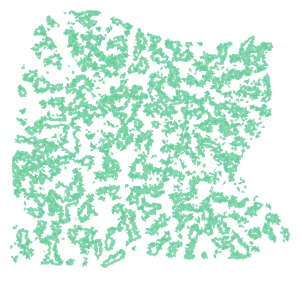

In [25]:
GF_L1 = GF_bin20[GF_bin20.obs["Layer"]=="L1"]
GF_points_l1 = GF_L1.obsm["spatial"]
GF_points_l1 = GF_points_l1.toarray().tolist()
GF_points_l1_res = alphashape.alphashape(GF_points_l1, alpha=0.03)
GF_points_l1_res.boundary

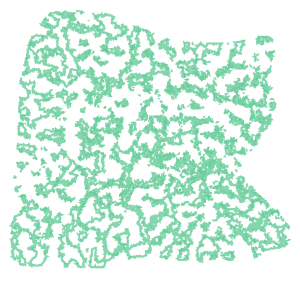

In [11]:
GF_L9 = GF_bin20[GF_bin20.obs["Layer"].isin(["L9"])]
GF_points_l9 = GF_L9.obsm["spatial"]
GF_points_l9 = GF_points_l9.toarray().tolist()
GF_points_l9_res = alphashape.alphashape(GF_points_l9, alpha=0.03)
GF_points_l9_res.boundary

In [34]:
GF_bin20[GF_bin20.obs["Lpl"]!=0]
np.max(GF_bin20[GF_bin20.obs["Lpl"]!=0].obs["Lpl"])

5.39280166333204

In [44]:
os.chdir("/share/appspace_data/shared_groups/bgi_liujz_bgi_liujz/wujunshu")
SPF_bin20 = sc.read_h5ad("SPF_liver_bin20_add_score.h5ad")
SPF_bin20.obsm["spatial"] = SPF_bin20.obs.loc[:,["x", "y"]].values

SPFmeta = pd.read_csv("meta.data.SPF.layers.new.tsv", header=0, sep="\t", index_col=0)
SPF_bin20.obs[['Kuffer1','Plasma1', 'NKT1', 'DC1', 'Neu1','Lpl','Zbtb20',"Layer"]] = SPFmeta.loc[:,['Kuffer1', 'Plasma1','NKT1', 'DC1', 'Neu1','Lpl','Zbtb20',"Layer"]].reindex(SPF_bin20.obs.index)
SPF_bin20

AnnData object with n_obs × n_vars = 410282 × 23239
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'cell', 'x', 'y', 'Kuffer1', 'Plasma1', 'NKT1', 'NKT_raw1', 'Kuffer_raw1', 'Plasma_raw1', 'DC1', 'Neu1', 'DC_raw1', 'Neu_raw1', 'Lpl', 'Zbtb20', 'Layer'
    var: 'features'
    obsm: 'spatial'

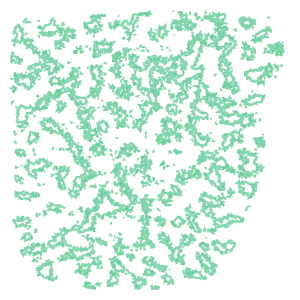

In [31]:
SPF_L1 = SPF_bin20[SPF_bin20.obs["Layer"]=="L1"]
SPF_points = SPF_L1.obsm["spatial"]
SPF_points = SPF_points.toarray().tolist()
SPF_points_res = alphashape.alphashape(SPF_points, alpha=0.03)
SPF_points_res.boundary

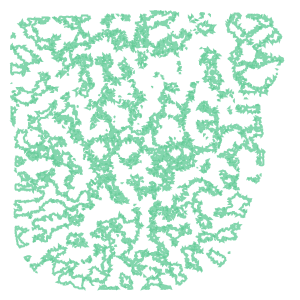

In [32]:
SPF_L9 = SPF_bin20[SPF_bin20.obs["Layer"].isin(["L9"])]
SPF_points_l9 = SPF_L9.obsm["spatial"]
SPF_points_l9 = SPF_points_l9.toarray().tolist()
SPF_points_l9_res = alphashape.alphashape(SPF_points_l9, alpha=0.03)
SPF_points_l9_res.boundary



In [33]:
SPF_bin20[SPF_bin20.obs["Lpl"]!=0]
np.max(GF_bin20[GF_bin20.obs["Lpl"]!=0].obs["Lpl"])

5.39280166333204

In [35]:
GF_Kuffer_max = np.max(GF_bin20[GF_bin20.obs["Lpl"]!=0].obs["Lpl"])
SPF_Kuffer_max = np.max(SPF_bin20[SPF_bin20.obs["Lpl"]!=0].obs["Lpl"])
kuffer_max = np.max([GF_Kuffer_max, SPF_Kuffer_max])

In [36]:
kuffer_max

5.39280166333204

[2.56 3.28 4.  ]


<Figure size 640x480 with 0 Axes>

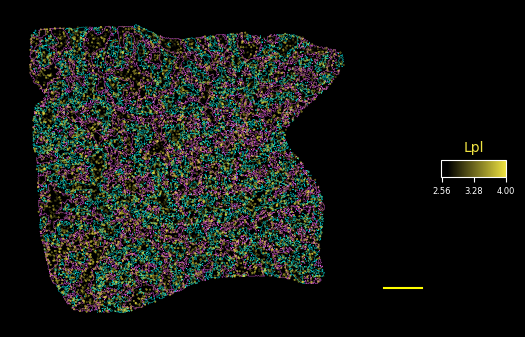

In [42]:
#plt.style.use("default")
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

#sc.pl.spatial(GF_bin20[GF_bin20.obs["Kuffer1"]!=0], color="Kuffer1", spot_size=50, title="GF Kuffer", frameon=False, show=False, ax=ax, 
#              cmap=YellowCM, vmin=0, vmax=0.5)


fig, ax = plot_spatial(adata=GF_bin20[GF_bin20.obs["Lpl"]!=0], color=["Lpl"], show_img=False, labels=["Lpl"], 
                          circle_diameter=0.3, alpha_scaling=1.0, max_col=(4, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf),
                            max_color_quantile=1,  img=None, img_alpha=0, adjust_text=True, plt_axis="off",
                            axis_y_flipped=True, x_y_labels=("", ""), text_box_alpha=0.9, reorder_cmap=[0], style="fast",
                            colorbar_position="right", colorbar_label_kw={"size":10}, colorbar_shape={}, colorbar_tick_size=6,
                            colorbar_grid=[1,1], white_spacing=10)#, image_cmap="Greys_r"

def shapely_to_paths(g):
    if isinstance(g, MultiLineString):
        return [list(ls.coords) for ls in g.geoms]
    else:
        raise Exception('unhandled shapely geometry: %s' % type(g))

# 获取路径
paths = shapely_to_paths(GF_points_l1_res.boundary)
# 遍历路径并添加到图表中
for path in paths:
    # 解包路径中的坐标
    x, y = zip(*path)
    # 绘制线条
    ax.plot(x, y, color="cyan", linewidth=0.25, alpha=1, zorder=0)

paths_l9 = shapely_to_paths(GF_points_l9_res.boundary)
# 遍历路径并添加到图表中
for path in paths_l9:
    # 解包路径中的坐标
    x, y = zip(*path)
    # 绘制线条
    ax.plot(x, y, color="#FF66FF", linewidth=0.25, alpha=1,zorder=0)

point0 = [20000, 20000]
point1 = [22000, 20000]
ax.plot([point0[0], point1[0]], [point0[1], point1[1]], color='yellow', linestyle="-")
plt.show()
plt.savefig("GF.Lpl.l1l9.test.pdf")

[1.94 2.97 4.  ]


<Figure size 640x480 with 0 Axes>

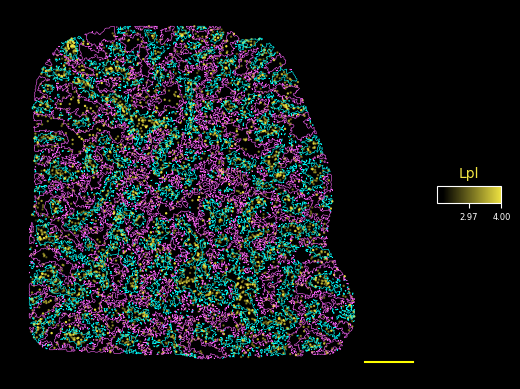

In [43]:
#plt.style.use("default")
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

#sc.pl.spatial(GF_bin20[GF_bin20.obs["Kuffer1"]!=0], color="Kuffer1", spot_size=50, title="GF Kuffer", frameon=False, show=False, ax=ax, 
#              cmap=YellowCM, vmin=0, vmax=0.5)


fig, ax = plot_spatial(adata=SPF_bin20[SPF_bin20.obs["Lpl"]!=0], color=["Lpl"], show_img=False, labels=["Lpl"], 
                          circle_diameter=0.7, alpha_scaling=1.0, max_col=(4, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf),
                            max_color_quantile=1,  img=None, img_alpha=0, adjust_text=True, plt_axis="off",
                            axis_y_flipped=True, x_y_labels=("", ""), text_box_alpha=0.9, reorder_cmap=[0], style="fast",
                            colorbar_position="right", colorbar_label_kw={"size":10}, colorbar_shape={}, colorbar_tick_size=6,
                            colorbar_grid=[1,1], white_spacing=10)#, image_cmap="Greys_r"

def shapely_to_paths(g):
    if isinstance(g, MultiLineString):
        return [list(ls.coords) for ls in g.geoms]
    else:
        raise Exception('unhandled shapely geometry: %s' % type(g))



#获取路径
paths = shapely_to_paths(SPF_points_res.boundary)
# 遍历路径并添加到图表中
for path in paths:
    # 解包路径中的坐标
    x, y = zip(*path)
    # 绘制线条
    ax.plot(x, y, color="cyan", linewidth=0.4, alpha=1)

paths_l9 = shapely_to_paths(SPF_points_l9_res.boundary)
# 遍历路径并添加到图表中
for path in paths_l9:
    # 解包路径中的坐标
    x, y = zip(*path)
    # 绘制线条
    ax.plot(x, y, color="#FF66FF", linewidth=0.4, alpha=1)

point0 = [20000, 20000]
point1 = [22000, 20000]
ax.plot([point0[0], point1[0]], [point0[1], point1[1]], color='yellow', linestyle="-")
plt.show()
plt.savefig("SPF.Lpl.l1l9.test.pdf")